# py_merit-functions.ipynb

## Lecture 6 of CMU16-745 (2025)

Use JAX for automatic differentiation

Feb 14, 25 Refine code. 

* Remove wrapper function for dc().
* Add reshape(2,1) to input.

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from jax.numpy.linalg import norm, solve
import jax
import jax.numpy as jnp

In [4]:
Q = np.diag([0.5,1])
Q
# objective function
def f(x):
    x1 = jnp.array(x) - jnp.array([[1],[0]])
    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = np.array(x) - np.array([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q


In [16]:
# constraint and gradient (improved)

def c(x):
    return (x[0]**2 + 2*x[0] - x[1]).item()  # correction to return scalar value

def dc(x):
    return jnp.asarray([2*x[0]+2, [-1]]).reshape(1,2) # minor correction to return clean array


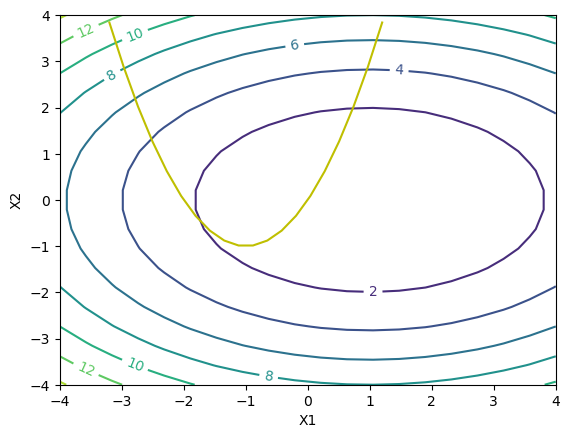

In [6]:
def plot_landscape():
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f([[X[j,k]], [Y[j,k]]])
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    xc = np.linspace(-3.2,1.2, Nsamp)
    yc = xc**2+2.0*xc
    ax.plot(xc,yc,'y-')

    return ax

ax = plot_landscape()   

In [56]:
def gauss_newton_step(x0,lambda0):
    H = d2f(x0) # + jnp.asarray((jax.jacfwd(dc)(x0)).T*lambda0).reshape(2,2)
    C = dc(x0)
    #C = jnp.expand_dims(jnp.asarray(dc(x0)), axis=0)
    A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
    #x0a = jnp.expand_dims(x0,axis=1)
    B = jnp.vstack((-df(x0)-C.T*lambda0, -jnp.asarray(c(x0))))
    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    # !slight modification from previous. Return only the steps
    return dx, dlambda
    

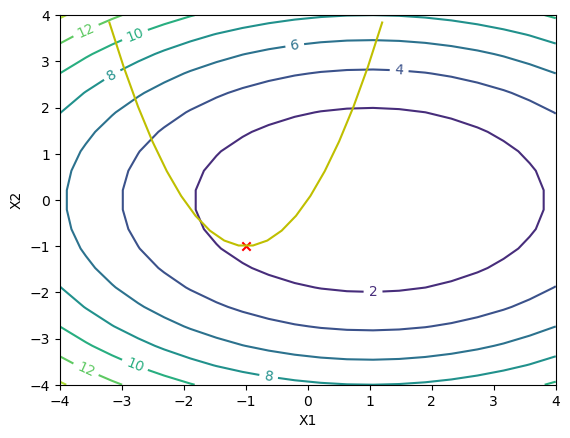

In [28]:
xguess = jnp.array([[-1.0],[-1.0]])
lambdaguess = [0.0]
i = 0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

In [19]:
def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if jnp.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m')   
    ax.set_title("Iteration : " + str(i))

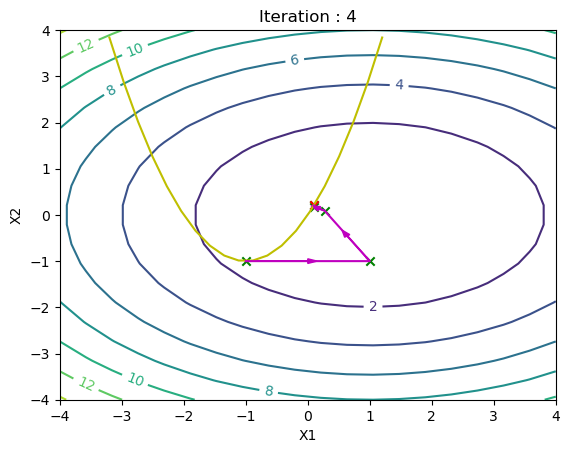

In [35]:
xr = xguess[:,-1].reshape(2,1)
dX, dLambda = gauss_newton_step(xr,lambdaguess[-1])
xguess = jnp.hstack((xguess, xr+dX))
lambdaguess.append(lambdaguess[-1]+dLambda)
i+=1
plot_steps(xguess,i)

In [46]:
def P(x, _lambda):
    dL_u = -df(x) - dc(x).T*_lambda
    dL = jnp.vstack((dL_u, -c(x)))
    return 0.5*jnp.dot(dL.T, dL)

def dP(x, _lambda):
    H = d2f(x)  + jnp.asarray((jax.jacfwd(dc)(x)).T*_lambda).reshape(2,2)
    #C = jnp.expand_dims(jnp.asarray(dc(x)), axis=0)
    C = dc(x)
    A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
    #xa = jnp.expand_dims(x,axis=1)
    B = jnp.vstack((-df(x)-C.T*_lambda, -jnp.asarray(c(x))))    
    return A@B

In [51]:
rho = 1.0
def P(x, _lambda):
    return f(x) + rho*norm(jnp.array([c(x)]),ord=1)

def dP(x, _lambda):
    C = dc(x)
    #C = jnp.expand_dims(jnp.asarray(dc(x)), axis=0)
    dp_u = df(x) + rho*C.T*jnp.sign(c(x))
    dp_l = jnp.zeros((1,1))
    return jnp.vstack((dp_u,dp_l))

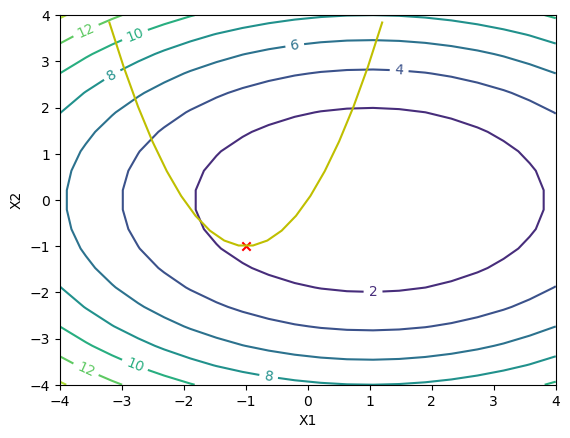

In [57]:
xguess = jnp.array([[-1.0],[-1.0]])
lambdaguess = [0.0]
i = 0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

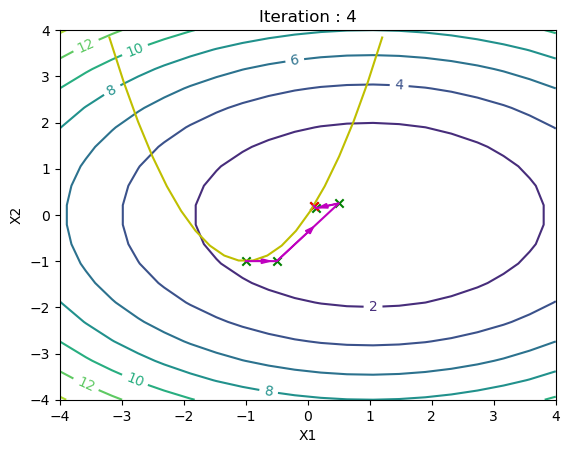

In [61]:
xr = xguess[:,-1].reshape(2,1)
dX, dLambda = gauss_newton_step(xr,lambdaguess[-1])
alpha = 1.0
xlast = xguess[:,-1].reshape(2,1)
while (P(xlast+alpha*dX, lambdaguess[-1]+alpha*dLambda) > P(xlast,lambdaguess[-1])
        + 0.01*alpha*jnp.dot(dP(xlast, lambdaguess[-1]).T,jnp.vstack((dX,dLambda)))):
    alpha = 0.5*alpha
xguess = jnp.hstack((xguess, xguess[:,-1].reshape(2,1)+alpha*dX))
lambdaguess.append(lambdaguess[-1]+alpha*dLambda)
i+=1
plot_steps(xguess,i)